In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# from google.colab import drive
# drive.mount('/content/gdrive')

# Load the data
data = pd.read_excel('DailyDelhiClimateTrain.xlsx', parse_dates=['date'], index_col='date')


In [2]:
# Check for duplicate timestamps
duplicates = data.index.duplicated()
if duplicates.any():
    print("Duplicates found:", data.index[duplicates])
else:
    print("No duplicates found.")

No duplicates found.


In [3]:
# Aggregate data by taking the mean for each hour if duplicates are found
data = data.groupby(data.index).mean()

In [4]:
# Basic descriptive statistics
print(data.describe())

Q1 = data['meantemp'].quantile(0.25)
Q3 = data['meantemp'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data = data[(data['meantemp'] >= lower_bound) & (data['meantemp'] <= upper_bound)]
print()
print(data.describe())

          meantemp     humidity   wind_speed  meanpressure
count  1461.000000  1461.000000  1461.000000   1461.000000
mean     25.506127    60.744851     6.806865   1011.101197
std       7.339416    16.743928     4.559688    180.293335
min       6.000000    13.428571     0.000000     -3.041667
25%      18.857143    50.375000     3.475000   1001.571429
50%      27.714286    62.625000     6.250000   1008.555556
75%      31.312500    72.125000     9.250000   1014.937500
max      38.714286    98.000000    42.220000   7679.333333

          meantemp     humidity   wind_speed  meanpressure
count  1461.000000  1461.000000  1461.000000   1461.000000
mean     25.506127    60.744851     6.806865   1011.101197
std       7.339416    16.743928     4.559688    180.293335
min       6.000000    13.428571     0.000000     -3.041667
25%      18.857143    50.375000     3.475000   1001.571429
50%      27.714286    62.625000     6.250000   1008.555556
75%      31.312500    72.125000     9.250000   1014.937

In [5]:
# Set the expected frequency to hourly
data = data.asfreq('D')

# Recount missing values after ensuring hourly frequency
missing_values_count = data['meantemp'].isnull().sum()
print(f"Number of missing values in 'meantemp' after setting hourly frequency: {missing_values_count}")

Number of missing values in 'meantemp' after setting hourly frequency: 0


In [6]:
# linear interpolation for missing values
data['meantemp'] = data['meantemp'].interpolate(method='linear')

# Recount missing values after ensuring hourly frequency
missing_values_count = data['meantemp'].isnull().sum()
print(f"Number of missing values in 'meantemp' after setting hourly frequency: {missing_values_count}")

Number of missing values in 'meantemp' after setting hourly frequency: 0


Skewness:  -0.4461322636404364
Kurtosis:  -0.9379486547218705


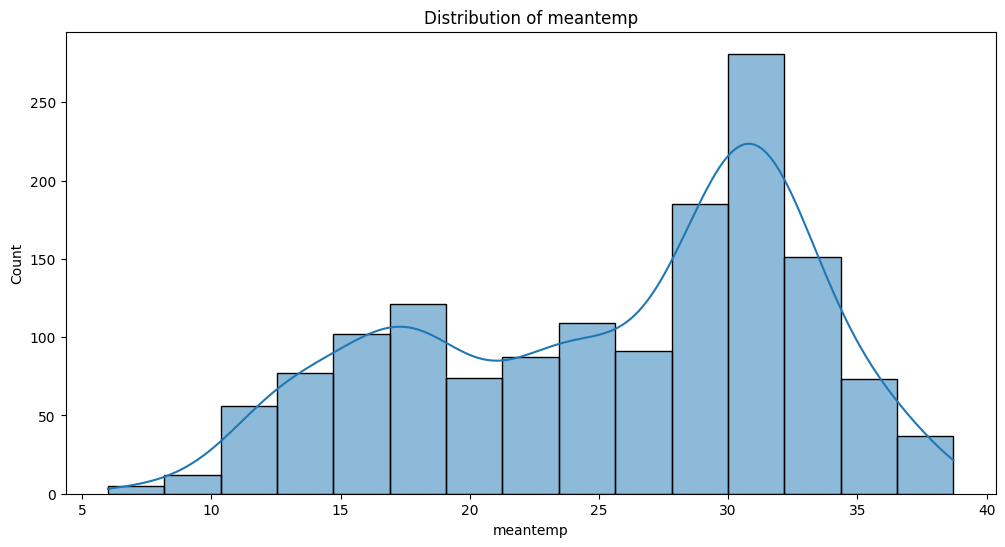

In [7]:
# Skewness and Kurtosis
print("Skewness: ", data['meantemp'].skew())
print("Kurtosis: ", data['meantemp'].kurt())

# Histogram and density plot
plt.figure(figsize=(12, 6))
sns.histplot(data['meantemp'], kde=True)
plt.title('Distribution of meantemp')
plt.show()

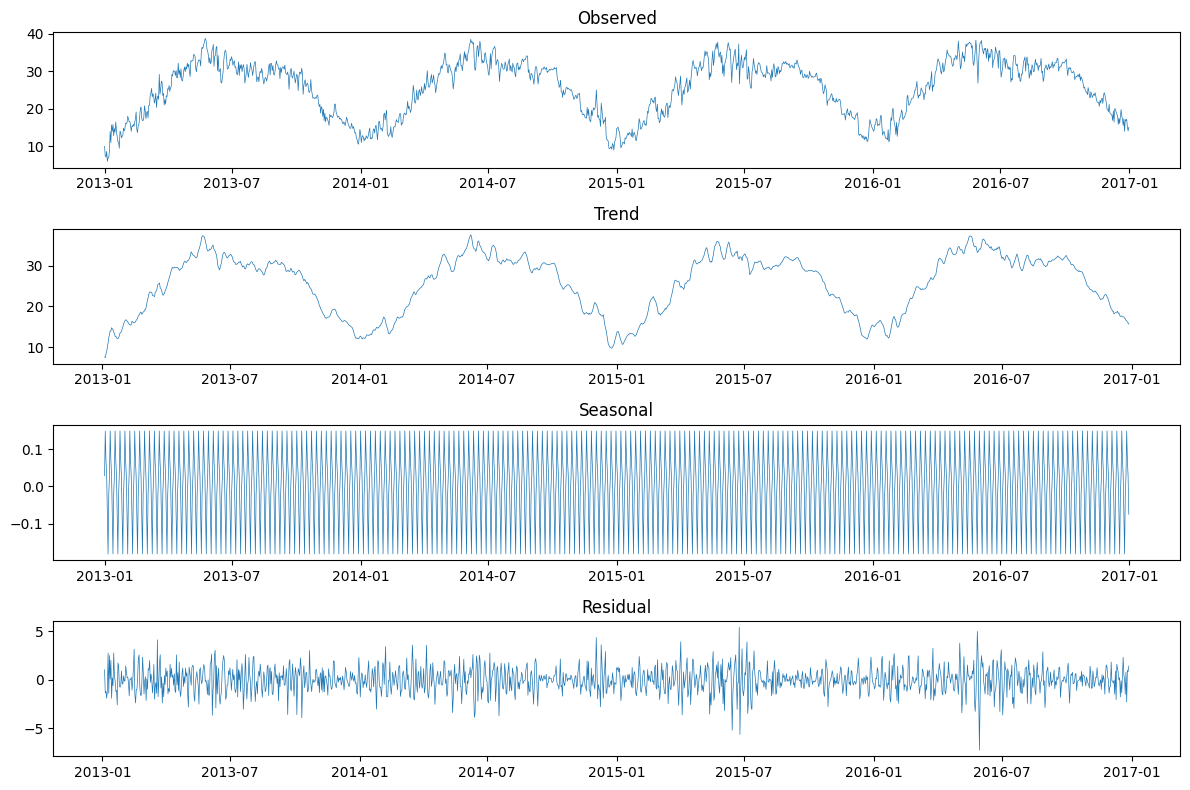

In [8]:
# Assuming 'data' is your DataFrame indexed by DateTime and 'meantemp' is the time series column
decomposition = seasonal_decompose(data['meantemp'], model='additive')

# Decompose and get the result
# result = decomposition.plot()

# Manually adjust the plots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))

# Plot each component with adjusted line width
ax1.plot(decomposition.observed, linewidth=0.5)
ax1.set_title('Observed', fontsize=12)

ax2.plot(decomposition.trend, linewidth=0.5)
ax2.set_title('Trend', fontsize=12)

ax3.plot(decomposition.seasonal, linewidth=0.5)
ax3.set_title('Seasonal', fontsize=12)

ax4.plot(decomposition.resid, linewidth=0.5)
ax4.set_title('Residual', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()


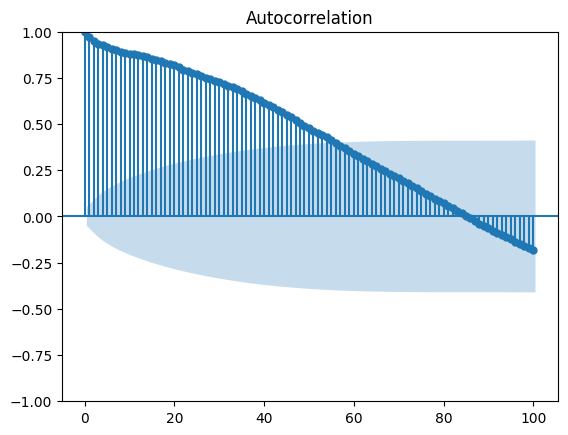

The minimum y-value is -0.18294065293862544 at lag 100.


In [10]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Plot ACF
plot_acf(data['meantemp'], lags=100)  # Plot first 100 lags to start
plt.show()

# Calculate ACF values for the first 100 lags
acf_values = acf(data['meantemp'], nlags=100)

# Find the lag where the ACF is minimum
min_acf_value = min(acf_values)
min_acf_lag = acf_values.tolist().index(min_acf_value)

print(f"The minimum y-value is {min_acf_value} at lag {min_acf_lag}.")

# Use ACF and PACF plots to inform your decision on lag length.
# Then use statistical tests with this lag length.

# Look for the point at which the autocorrelations in the ACF/PACF plots drop off and become insignificant.
# A common heuristic is to look for the 'elbow' in these plots—the point where the correlation coefficients drop and then hover around zero.

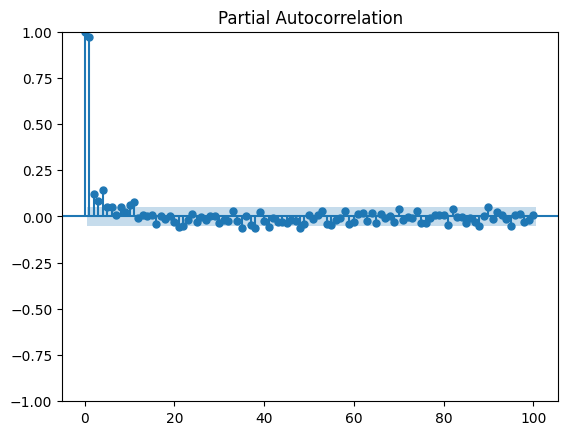

In [11]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

# Plot PACF
plot_pacf(data['meantemp'], lags=100)  # Plot first 100 lags to start
plt.show()

# Calculate PACF values for the first 100 lags
pacf_values = pacf(data['meantemp'], nlags=100)

# Find the lag where the PACF is minimum
min_pacf_value = min(pacf_values)
min_pacf_lag = pacf_values.tolist().index(min_pacf_value)


# Use ACF and PACF plots to inform your decision on lag length.
# Then use statistical tests with this lag length.

# Look for the point at which the autocorrelations in the ACF/PACF plots drop off and become insignificant.
# A common heuristic is to look for the 'elbow' in these plots—the point where the correlation coefficients drop and then hover around zero.

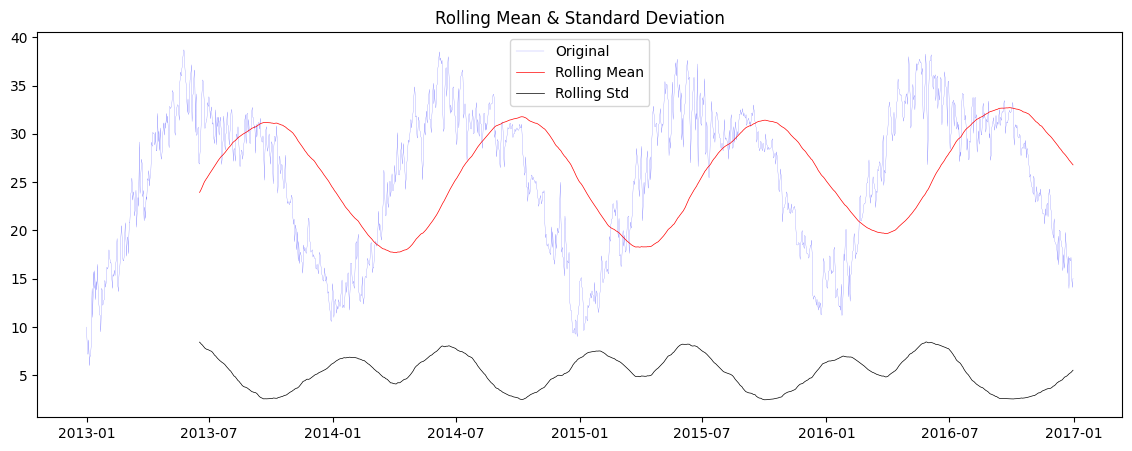

In [12]:
# Check for stationarity
# Calculate rolling statistics
rolling_mean = data['meantemp'].rolling(window=24*7).mean()  # 1-week rolling mean
rolling_std = data['meantemp'].rolling(window=24*7).std()  # 1-week rolling standard deviation

# Plot rolling statistics
plt.figure(figsize=(14, 5))
plt.plot(data['meantemp'], color='blue', label='Original', linewidth=0.1)
plt.plot(rolling_mean, color='red', label='Rolling Mean', linewidth=0.5)
plt.plot(rolling_std, color='black', label='Rolling Std', linewidth=0.5)
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

In [13]:
from statsmodels.tsa.stattools import adfuller
# Perform Dickey-Fuller test
adf_result = adfuller(data['meantemp'])

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

# Check p-value
if adf_result[1] < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")


ADF Statistic: -2.155565
p-value: 0.222766
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
The time series is not stationary.


In [14]:
# Perform differencing
data['meantemp_diff1'] = data['meantemp'].diff(periods=1)

# Remove the first NaN value
data = data.dropna()

print(data)

             meantemp   humidity  wind_speed  meanpressure  meantemp_diff1
date                                                                      
2013-01-02   7.400000  92.000000    2.980000   1017.800000       -2.600000
2013-01-03   7.166667  87.000000    4.633333   1018.666667       -0.233333
2013-01-04   8.666667  71.333333    1.233333   1017.166667        1.500000
2013-01-05   6.000000  86.833333    3.700000   1016.500000       -2.666667
2013-01-06   7.000000  82.800000    1.480000   1018.000000        1.000000
...               ...        ...         ...           ...             ...
2016-12-27  16.850000  67.550000    8.335000   1017.200000       -0.292857
2016-12-28  17.217391  68.043478    3.547826   1015.565217        0.367391
2016-12-29  15.238095  87.857143    6.000000   1016.904762       -1.979296
2016-12-30  14.095238  89.666667    6.266667   1017.904762       -1.142857
2016-12-31  15.052632  87.000000    7.325000   1016.100000        0.957393

[1460 rows x 5 columns]


In [15]:
adf_result = adfuller(data['meantemp_diff1'])

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

# Check p-value
if adf_result[1] < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")


ADF Statistic: -16.520441
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
The time series is stationary.


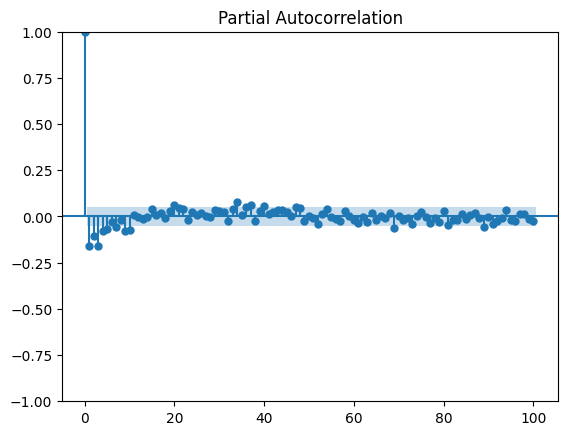

In [16]:
# Plot PACF on differenced
plot_pacf(data['meantemp_diff1'], lags=100)  # Plot first 100 lags to start
plt.show()

# Calculate PACF values for the first 100 lags
pacf_values = pacf(data['meantemp_diff1'], nlags=100)

# Find the lag where the PACF is minimum
min_pacf_value = min(pacf_values)
min_pacf_lag = pacf_values.tolist().index(min_pacf_value)


# Use ACF and PACF plots to inform your decision on lag length.
# Then use statistical tests with this lag length.

# Look for the point at which the autocorrelations in the ACF/PACF plots drop off and become insignificant.
# A common heuristic is to look for the 'elbow' in these plots—the point where the correlation coefficients drop and then hover around zero.

In [17]:
# Normalization for Neural Nets
data['meantemp_normalized'] = (data['meantemp'] - data['meantemp'].min()) / (data['meantemp'].max() - data['meantemp'].min())
data['meantemp_diff1_normalized'] = (data['meantemp_diff1'] - data['meantemp_diff1'].min()) / (data['meantemp_diff1'].max() - data['meantemp_diff1'].min())
# Basic descriptive statistics
print(data.describe())

          meantemp     humidity   wind_speed  meanpressure  meantemp_diff1  \
count  1460.000000  1460.000000  1460.000000   1460.000000     1460.000000   
mean     25.516747    60.728581     6.811527   1011.098070        0.003461   
std       7.330691    16.738107     4.557765    180.355072        1.666800   
min       6.000000    13.428571     0.000000     -3.041667      -10.625000   
25%      18.870536    50.359375     3.475000   1001.571429       -0.875000   
50%      27.727513    62.625000     6.250000   1008.527778        0.066964   
75%      31.317708    72.125000     9.250000   1014.890625        1.000000   
max      38.714286    98.000000    42.220000   7679.333333        6.666667   

       meantemp_normalized  meantemp_diff1_normalized  
count          1460.000000                1460.000000  
mean              0.596582                   0.614658  
std               0.224082                   0.096393  
min               0.000000                   0.000000  
25%              

In [18]:
from google.colab import drive
drive.mount('/content/gdrive')
data.to_excel('/content/gdrive/My Drive/processed_dataset2.xlsx')

Mounted at /content/gdrive


In [19]:
# Load the data
proc_data = pd.read_excel('/content/gdrive/My Drive/processed_dataset2.xlsx', parse_dates=['date'], index_col='date')

In [20]:
# Check for duplicate timestamps
duplicates = proc_data.index.duplicated()
if duplicates.any():
    print("Duplicates found:", proc_data.index[duplicates])
else:
    print("No duplicates found.")

# Set the expected frequency to daily
proc_data = proc_data.asfreq('D')

# Recount missing values after ensuring hourly frequency
missing_values_count = proc_data['meantemp_normalized'].isnull().sum()
print(f"Number of missing values in 'meantemp_normalized' after setting hourly frequency: {missing_values_count}")

No duplicates found.
Number of missing values in 'meantemp_normalized' after setting hourly frequency: 0
